In [26]:
def calculate_rs1i(data, column_name='Closing_price', period=14):
    data[column_name] = pd.to_numeric(data[column_name], errors='coerce')
    #data = data.dropna(subset=[column_name])
    
    delta = data[column_name].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi.fillna(0)

def calculate_macd(data: pd.DataFrame, column_name: str = 'Closing_price', short_period: int = 12, long_period: int = 26, signal_period: int = 9) -> pd.DataFrame:
    """
    Calculate the Moving Average Convergence Divergence (MACD) and its Signal Line for a given DataFrame.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing the price data.
    - column_name (str): The name of the column to calculate MACD on (default is 'Closing_price').
    - short_period (int): The short period for the fast EMA (default is 12).
    - long_period (int): The long period for the slow EMA (default is 26).
    - signal_period (int): The period for the Signal Line (default is 9).

    Returns:
    - pd.DataFrame: A DataFrame containing the MACD, Signal Line, and the MACD Histogram.
    """
    
    # Ensure the column exists
    if column_name not in data.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    
    # Calculate the short-term EMA (12-period)
    short_ema = data[column_name].ewm(span=short_period, adjust=False).mean()
    
    # Calculate the long-term EMA (26-period)
    long_ema = data[column_name].ewm(span=long_period, adjust=False).mean()
    
    # Calculate the MACD (difference between short-term and long-term EMAs)
    macd = short_ema - long_ema
    
    # Calculate the Signal Line (9-period EMA of the MACD)
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    
    # Calculate the MACD Histogram (difference between MACD and Signal Line)
    macd_histogram = macd - signal_line
    
    # Create a DataFrame with the MACD, Signal Line, and Histogram
    macd_df = pd.DataFrame({
        'MACD': macd,
        'Signal_Line': signal_line,
        'MACD_Histogram': macd_histogram
    
    })
    
    return macd_df

import numpy as np
import pandas as pd

def calculate_rsi(data: pd.DataFrame, column_name: str = 'Closing_price', period: int = 14) -> pd.Series:
    """
    Calculate the Relative Strength Index (RSI) for a given DataFrame.
    """

    # Ensure column exists
    if column_name not in data.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Step 1: Compute Price Changes
    delta = data[column_name].diff().fillna(0)

    # Step 2: Separate gains and losses
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    # Step 3: Compute Moving Averages (Fixing Instability)
    avg_gain = pd.Series(gain).rolling(window=period, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=period, min_periods=1).mean()

    # Step 4: Compute RS (Avoiding Division by Zero)
    epsilon = 1e-10  # Small constant to prevent division errors
    rs = avg_gain / (avg_loss + epsilon)

    # Step 5: Compute RSI
    rsi = 100 - (100 / (1 + rs))

    # Ensure no NaN values
    return pd.Series(rsi, index=data.index, name=f"RSI_{period}").fillna(50)  # Default RSI to 50 if unknown


Select a currency pair from the following:
1. USD/INR
2. EUR/INR
3. JPY/INR
4. GBP/INR
Index(['Open_price', 'Day_high', 'Day_low', 'Closing_price', 'Currency Pair'], dtype='object')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

c:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\swing_technical_indicators\indicators.py:202: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bands.fillna(method='ffill', inplace=True)  # Forward-fill
c:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\swing_technical_indicators\indicators.py:203: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bands.fillna(method='bfill', inplace=True)  # Backward-fill
d:\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
d:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

Predicted Closing Prices for Next 7 Days:
Day 1: 2.4908
Day 2: 2.4307
Day 3: 2.5781
Day 4: 2.4007
Day 5: 2.4768
Day 6: 2.4406
Day 7: 2.4254


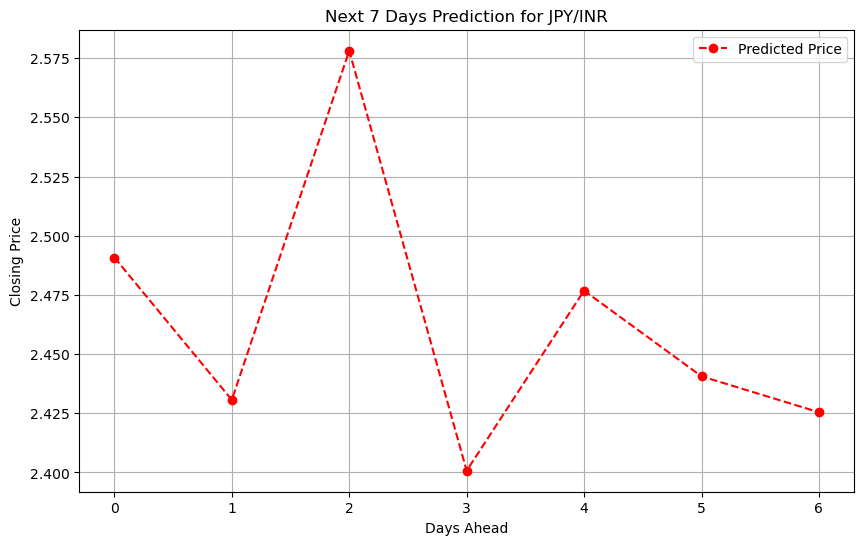

Index(['Open_price', 'Day_high', 'Day_low', 'Deseasonalized_Day_high',
       'Deseasonalized_Day_low', 'Deseasonalized_Open_price', 'EMA_100',
       'EMA_200', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'MACD_Histogram',
       'SMA', 'Upper Band', 'Lower Band'],
      dtype='object')

In [37]:
# User selects a currency pair
import joblib
import os
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import swing_technical_indicators 

# Set API Key for Alpha Vantage
#api_key = '89PMD611NPUTS89W'
api_key = 'EWTP9LXAZRDLRHB8'

# Function to fetch Forex data
def fetch_forex_data(from_currency, to_currency):
    url = f'https://www.alphavantage.co/query'
    params = {
        'function': 'FX_DAILY',
        'from_symbol': from_currency,
        'to_symbol': to_currency,
        'apikey': api_key,
        'outputsize': 'compact'
    }
    response = requests.get(url, params=params)
    data = response.json()

    time_series = data.get('Time Series FX (Daily)', {})
    df = pd.DataFrame.from_dict(time_series, orient='index')
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    df.rename(columns={
        "1. open": "Open_price",
        "2. high": "Day_high",
        "3. low": "Day_low",
        "4. close": "Closing_price"
    }, inplace=True)

    df['Currency Pair'] = f'{from_currency}/{to_currency}'

    # Filter past 60 days to ensure enough data for sequences
    last_100_days = datetime.now() - timedelta(days=100)
    df = df[df.index >= last_100_days]

    return df

# Available currency pairs
currency_pairs = ["USD/INR", "EUR/INR", "JPY/INR", "GBP/INR"]

print("Select a currency pair from the following:")
for i, pair in enumerate(currency_pairs, 1):
    print(f"{i}. {pair}")

choice = int(input("Enter the number corresponding to your choice: "))
selected_pair = currency_pairs[choice - 1]

from_currency, to_currency = selected_pair.split("/")

# Fetch data for selected currency pair
df = fetch_forex_data(from_currency, to_currency)
print(df.columns)
df["Open_price"] = pd.to_numeric(df["Open_price"], errors='coerce')
df["Day_high"] = pd.to_numeric(df["Day_high"], errors='coerce')
df["Day_low"] = pd.to_numeric(df["Day_low"], errors='coerce')
df["Closing_price"] = pd.to_numeric(df["Closing_price"], errors='coerce')

#print(df.dtypes)
from statsmodels.tsa.seasonal import seasonal_decompose

def deseasonalize_column(data, column, period=7):
    # Decompose the column
    decomposition = seasonal_decompose(data[column], model='additive', period=period, extrapolate_trend='freq')
    
    # Extract the residual component as deseasonalized data
    deseasonalized = data[column] - decomposition.seasonal
    
    return deseasonalized

# Identify non-stationary columns
non_stationary_columns = ['Day_high', 'Day_low', 'Open_price']

# Create deseasonalized columns
for col in non_stationary_columns:
    deseasonalized_col = deseasonalize_column(df, col, period=14)  # Adjust the period as needed
    df[f'Deseasonalized_{col}'] = deseasonalized_col

df['EMA_100'] = swing_technical_indicators.calculate_100ema(df, 'Closing_price', 100)
df['EMA_200'] = swing_technical_indicators.calculate_200ema(df, 'Closing_price', 200)
df['EMA_50'] = swing_technical_indicators.calculate_100ema(df, 'Closing_price', 50)
df['RSI'] = calculate_rsi(df,'Closing_price',21)

data_macd = calculate_macd(df, column_name='Closing_price', short_period=12, long_period=26, signal_period=9)
#print(data_macd.columns)

for i in data_macd.columns:
    #print(i)
    df[f"{i}"] = data_macd[i]

bollinger_data = swing_technical_indicators.calculate_bollinger_bands(df['Closing_price'])
y = df["Closing_price"]
df = df.join(bollinger_data)
df.drop('Price',axis=1, inplace=True)
df.drop('Closing_price',axis=1, inplace=True)
df.drop('Currency Pair',axis=1, inplace=True)

# Load saved scalers

scaler_X = joblib.load(r'C:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\JPYINR\jpyinr_scalerx')
scaler_y = joblib.load(r'C:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\JPYINR\jpyinr_scalery')

# Normalize data
df_scaled = scaler_X.transform(df)
#print(df_scaled)
# Function to create sequences for CNN
def create_sequences(X, y, sequence_length, forecast_horizon=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length - forecast_horizon + 1):  
        X_seq.append(X[i:i + sequence_length])  
        y_seq.append(y[i + sequence_length : i + sequence_length + forecast_horizon])  # Next 7 values
    return np.array(X_seq), np.array(y_seq)



# Create sequences
X_seq, y_seq = create_sequences(df_scaled,y,sequence_length = 30,forecast_horizon=7)
#print(X_seq)
# Ensure correct input shape
sequence_length = 30
feature_count = X_seq.shape[2]  # Number of features

# Define CNN Model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(sequence_length, feature_count)),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(7)  # Output layer for predicting next 7 days
])

# Load saved weights
cnn_model.load_weights(r"C:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\JPYINR\cnn_model.h5")
#print(cnn_model.get_weights())
# Predict next 7 days
y_pred_scaled = cnn_model.predict(X_seq[-1].reshape(1, sequence_length, feature_count)+7)

#print(y_pred_scaled)
# Convert predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Print results
print("\nPredicted Closing Prices for Next 7 Days:")
for i, price in enumerate(y_pred.flatten(), 1):
    print(f"Day {i}: {price:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot( y_pred.flatten(), marker='o', linestyle="--", color="red", label="Predicted Price")
plt.xlabel("Days Ahead")
plt.ylabel("Closing Price")
plt.title(f"Next 7 Days Prediction for {selected_pair}")
plt.legend()
plt.grid()
plt.show()


df.columns


In [14]:
df2 = pd.read_csv(r"C:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\Dataset\all_data.csv")
df2 = df2[df2['Currency Pair'] == "JPY/INR"]
df2

,Unnamed: 0,Date,Open_price,Day_high,Day_low,Closing_price,Currency Pair
5230,5230,2014-11-07,0.53595,0.53913,0.53381,0.53587,JPY/INR
5231,5231,2014-11-10,0.53616,0.53963,0.53489,0.53593,JPY/INR
5232,5232,2014-11-11,0.53137,0.53415,0.53018,0.53086,JPY/INR
5233,5233,2014-11-12,0.53080,0.53446,0.53045,0.53083,JPY/INR
5234,5234,2014-11-13,0.53094,0.53298,0.53065,0.53137,JPY/INR
...,...,...,...,...,...,...,...
7846,7846,2024-11-20,0.54539,0.54563,0.54097,0.54239,JPY/INR
7847,7847,2024-11-21,0.54249,0.54823,0.54249,0.54646,JPY/INR
7848,7848,2024-11-22,0.54659,0.54834,0.54484,0.54499,JPY/INR
7849,7849,2024-11-25,0.54718,0.54918,0.54457,0.54610,JPY/INR


In [31]:
df2['RSI'] = swing_technical_indicators.calculate_rsi(df2,'Closing_price',14)
df2['RSI']

5230   NaN
5231   NaN
5232   NaN
5233   NaN
5234   NaN
        ..
7846   NaN
7847   NaN
7848   NaN
7849   NaN
7850   NaN
Name: RSI, Length: 2621, dtype: float64

In [ ]:
nmskealnjfli